In [8]:
from ThesisPackage.Environments.multi_pong_sender_receiver_ball_onehot import PongEnvSenderReceiverBallOneHot
from ThesisPackage.RL.Centralized_PPO.multi_ppo import PPO_Multi_Agent_Centralized
from ThesisPackage.RL.Decentralized_PPO.util import flatten_list, reverse_flatten_list_with_agent_list
from ThesisPackage.Wrappers.vecWrapper import PettingZooVectorizationParallelWrapper
import torch
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [9]:
def make_env(max_episode_steps = 512, sequence_length = 1, vocab_size = 3):
    env = PongEnvSenderReceiverBallOneHot(width=20, height=20, vocab_size=vocab_size, sequence_length=sequence_length, max_episode_steps=max_episode_steps)
    # env = ParallelFrameStack(env, 4)
    return env

In [10]:
def load(path="models/checkpoints"):
    env = make_env()
    models = {}
    for model in os.listdir(path):
        if "pong" in model:
            state_dict = torch.load(os.path.join(path, model))
            timestamp = model.split("_")[-1]
            timestamp = int(timestamp.split(".")[0])
            agent = PPO_Multi_Agent_Centralized(env, device="cpu")
            agent.agent.load_state_dict(state_dict)
            models[timestamp] = agent
    return models

In [11]:
def record_observations(env, agent, epochs=1, tracking_agent="paddle_1"):
    language_importances = []
    obs, info = env.reset()
    state = env.state()
    average_length = []

    observations = []

    for i in range(epochs):
        timestep = 0
        while True:
            timestep += 1
            obs = [obs]
            state = [state]
            obs = np.array(flatten_list(obs))
            observations.append(obs)
            state = np.array(flatten_list(state))

            obs = torch.tensor(obs, dtype=torch.float32)
            state = torch.tensor(state, dtype=torch.float32)
            with torch.no_grad():
                actions, _, _, _ = agent.agent.get_action_and_value(obs, state)
                actions = reverse_flatten_list_with_agent_list(actions, agent.agents)

            actions = actions[0]
            actions = {agent: action.cpu().numpy() for agent, action in actions.items()}

            obs, _, truncations, terminations, infos = env.step(actions)
            state = env.state()

            if any([truncations[agent] or terminations[agent] for agent in env.agents]):
                average_length.append(timestep)
                obs, info = env.reset()
                state = env.state()
                break
    return np.array(observations), average_length

In [12]:
num_steps = 10000
agents = load("/Users/cowolff/Documents/GitHub/ma.pong_rl/Plotting/saliencies_live/Multi_Pong/Sequence_Length_1")
agent_indizes = list(agents.keys())
agent_indizes.sort()
env = make_env(max_episode_steps=2048)

In [13]:
results = {}

In [14]:
env = make_env()
observations, average_length = record_observations(env, agents[agent_indizes[-1]], epochs=1000)

shape = observations.shape
new_shape = (shape[0] * shape[1], shape[2])
observations = observations.reshape(new_shape)
observations = np.array(observations, dtype=np.float32)

# normalize data between 0 and 1 based of the env observation space min and max
low = env.observation_space(env.agents[0]).low
high = env.observation_space(env.agents[0]).high

observations = (observations - low) / (high - low)

In [15]:
from torch.utils.data import Dataset, DataLoader

class ObservationsDataset(Dataset):
    def __init__(self, observations):
        self.observations = observations

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        return self.observations[idx]

In [16]:
import torch.nn as nn
import torch.optim as optim

# Define the neural network
class Classifier(nn.Module):
    def __init__(self, input_size):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, input_size)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        return self.fc3(x)


class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.sigmoid(self.fc3(x))

In [32]:
class InputEvaluationLoss(nn.Module):
    def __init__(self, agent_model, sequence_length, vocab_size):
        super(InputEvaluationLoss, self).__init__()
        self.agent_model = agent_model
        self.vocab_size = vocab_size
        self.sequence_length = sequence_length

    def forward(self, inputs, outputs, input_logits, output_logits):

        input_logits = self.agent_model(inputs)
        output_logits = self.agent_model(outputs)

        # Calculate KL divergence between the input_logits and output logits
        action_loss = -50 * F.mse_loss(input_logits[:,-1 * self.sequence_length * self.vocab_size:], output_logits[:,-1 * self.sequence_length * self.vocab_size:])

        # Calculate KL divergence between the inputs and outputs
        observation_loss = F.mse_loss(inputs, outputs) * 5e2

        total_loss = action_loss + observation_loss

        return total_loss, action_loss, observation_loss

In [33]:
dataset = ObservationsDataset(observations)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

manipulator = Classifier(observations.shape[-1])
discriminator = Discriminator(observations.shape[-1])

optimizer = optim.Adam(manipulator.parameters(), lr=0.00001)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.00001)
loss_function = InputEvaluationLoss(manipulator, 1, 3)
bceLoss = nn.BCELoss()

In [34]:
from torch.optim import lr_scheduler

agent_model = agents[agent_indizes[-1]].agent.actor
num_epochs = 120
step_size = 30  # Reduce learning rate every 30 epochs
gamma = 0.1     # Learning rate is reduced by a factor of 0.1

scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

disc_correct = 0
disc_total = 0

for epoch in range(num_epochs):
    for inputs in data_loader:
        optimizer.zero_grad()
        discriminator_optimizer.zero_grad()
        
        outputs = manipulator(inputs)
        
        # Get logits from agent model
        input_logits = agent_model(inputs)
        output_logits = agent_model(outputs)
        
        # Calculate original loss
        loss, action_loss, observation_loss = loss_function(inputs, outputs, input_logits, output_logits)
        
        # Prepare real and fake labels
        real_labels = torch.ones(inputs.size(0), 1)
        fake_labels = torch.zeros(inputs.size(0), 1)
        
        # Forward pass through discriminator
        real_outputs = discriminator(inputs)
        fake_outputs = discriminator(outputs.detach())
        
        # Calculate discriminator loss and update discriminator
        discriminator_loss = bceLoss(real_outputs, real_labels) + bceLoss(fake_outputs, fake_labels)
        discriminator_loss.backward()
        discriminator_optimizer.step()
        
        # Calculate generator (manipulator) loss
        fake_output_logits = discriminator(outputs)
        generator_loss = bceLoss(fake_output_logits, real_labels) * 0.01
        
        # Combine with original loss
        total_loss = loss + generator_loss
        total_loss.backward()
        optimizer.step()

        disc_predictions_real = (real_outputs > 0.5).float()
        disc_predictions_fake = (fake_outputs < 0.5).float()

        disc_correct += (disc_predictions_real == real_labels).sum().item()
        disc_correct += (disc_predictions_fake == fake_labels).sum().item()
        disc_total += real_labels.size(0) + fake_labels.size(0)
        
        action_loss, observation_loss = action_loss.item(), observation_loss.item()
        
    # Step the scheduler after each epoch
    scheduler.step()

    disc_accuracy = disc_correct / disc_total
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss.item():.4f}, Action Loss: {action_loss:.4f}, Observation Loss: {observation_loss:.4f}, Discriminator Loss: {discriminator_loss.item():.4f}, Generator Loss: {generator_loss.item():.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}, Discriminator Accuracy: {disc_accuracy:.4f}')

Epoch 1/120, Loss: 1.2710, Action Loss: -0.0035, Observation Loss: 1.2674, Discriminator Loss: 1.3787, Generator Loss: 0.0071, LR: 0.000010, Discriminator Accuracy: 0.4389
Epoch 2/120, Loss: 0.0564, Action Loss: -0.0010, Observation Loss: 0.0505, Discriminator Loss: 1.3881, Generator Loss: 0.0069, LR: 0.000010, Discriminator Accuracy: 0.4473
Epoch 3/120, Loss: 0.0396, Action Loss: -0.0005, Observation Loss: 0.0332, Discriminator Loss: 1.3872, Generator Loss: 0.0069, LR: 0.000010, Discriminator Accuracy: 0.4491
Epoch 4/120, Loss: 0.0253, Action Loss: -0.0006, Observation Loss: 0.0190, Discriminator Loss: 1.3849, Generator Loss: 0.0069, LR: 0.000010, Discriminator Accuracy: 0.4499
Epoch 5/120, Loss: 0.0143, Action Loss: -0.0001, Observation Loss: 0.0075, Discriminator Loss: 1.3865, Generator Loss: 0.0070, LR: 0.000010, Discriminator Accuracy: 0.4491
Epoch 6/120, Loss: 0.0102, Action Loss: -0.0002, Observation Loss: 0.0035, Discriminator Loss: 1.3841, Generator Loss: 0.0069, LR: 0.000010,

In [ ]:
# Extract random observation
observation = observations[np.random.randint(0, len(observations))]
observation = torch.tensor(observation, dtype=torch.float32)
observation = observation.unsqueeze(0)
with torch.no_grad():
    output = classifier(observation)

# Reverse the normalization
output = output * (high - low) + low
output = output.numpy()
observation = observation * (high - low) + low
observation = observation.numpy()

print(f"Output: {output}")
print(f" Input: {observation}")

Output: [[ 9.064074   -7.8240376  -4.8959265   9.413147   -2.3666458   5.639427
  -2.7702522   1.7421494   2.5491238  -5.3950977   0.9205036   0.07807133
   0.02102156]]
 Input: [[ 9.         -7.         -5.3053474   8.771       0.53816795 -0.8771
  -3.3414345   2.6431732  -0.7235718   0.6607933   1.          0.
   0.        ]]


In [ ]:
def record_testing(env, agent, classifier, epochs=1, tracking_agent="paddle_1"):
    language_importances = []
    obs, info = env.reset()
    state = env.state()
    average_length = []

    distances = []

    for i in range(epochs):
        timestep = 0
        tokens = []
        fake_tokens = []

        while True:
            timestep += 1
            obs = [obs]
            state = [state]

            obs = np.array(flatten_list(obs))
            state = np.array(flatten_list(state))

            # Get token and reverse one-hot encode
            token = obs[:, -3:]
            token = np.argmax(token, axis=1)
            tokens.append(token)

            normalized_obs = (obs - env.observation_space(env.agents[0]).low) / (env.observation_space(env.agents[0]).high - env.observation_space(env.agents[0]).low)

            obs = torch.tensor(obs, dtype=torch.float32)
            state = torch.tensor(state, dtype=torch.float32)
            with torch.no_grad():
                actions, _, _, _ = agent.agent.get_action_and_value(obs, state)
                actions = reverse_flatten_list_with_agent_list(actions, agent.agents)

                output_obs = classifier(torch.tensor(normalized_obs, dtype=torch.float32).unsqueeze(0))
                fake_actions, _, _, _ = agent.agent.get_action_and_value(output_obs[0], state)

            
            
            fake_token = fake_actions[:, -1].numpy()
            fake_tokens.append(fake_token)

            distance = np.abs(output_obs - normalized_obs)
            distances.append(distance.numpy()[0][0])

            actions = actions[0]
            actions = {agent: action.cpu().numpy() for agent, action in actions.items()}

            obs, _, truncations, terminations, infos = env.step(actions)
            state = env.state()

            if any([truncations[agent] or terminations[agent] for agent in env.agents]):
                average_length.append(timestep)
                obs, info = env.reset()
                state = env.state()
                break
    return average_length, np.array(distances), np.array(tokens), np.array(fake_tokens)

In [ ]:
average_length, distances, tokens, fake_tokens = record_testing(env, agents[agent_indizes[-1]], manipulator, epochs=1)
print(distances.shape)

(512, 13)


In [ ]:
for original, fake in zip(tokens, fake_tokens):
    print(f"Original: {original} Fake: {fake}")

Original: [1 0] Fake: [0 2]
Original: [1 1] Fake: [0 0]
Original: [0 2] Fake: [1 0]
Original: [0 2] Fake: [2 0]
Original: [0 1] Fake: [2 0]
Original: [1 1] Fake: [0 0]
Original: [1 0] Fake: [0 2]
Original: [1 1] Fake: [0 0]
Original: [1 1] Fake: [0 0]
Original: [2 2] Fake: [0 0]
Original: [1 2] Fake: [0 0]
Original: [0 2] Fake: [1 0]
Original: [1 1] Fake: [0 0]
Original: [2 0] Fake: [0 2]
Original: [1 2] Fake: [0 0]
Original: [2 2] Fake: [0 0]
Original: [1 1] Fake: [0 1]
Original: [0 0] Fake: [1 2]
Original: [2 2] Fake: [0 0]
Original: [2 1] Fake: [0 0]
Original: [0 1] Fake: [2 0]
Original: [2 1] Fake: [0 0]
Original: [2 1] Fake: [0 0]
Original: [2 2] Fake: [0 0]
Original: [1 1] Fake: [0 0]
Original: [1 0] Fake: [0 0]
Original: [0 1] Fake: [2 0]
Original: [1 0] Fake: [0 2]
Original: [2 2] Fake: [0 0]
Original: [2 0] Fake: [0 0]
Original: [1 1] Fake: [0 0]
Original: [2 1] Fake: [0 0]
Original: [1 2] Fake: [0 0]
Original: [0 0] Fake: [0 2]
Original: [0 1] Fake: [2 0]
Original: [1 1] Fake

In [ ]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

def plot_distances(distances, path=None, title="Heatmap for one epoch"):
    # Transposing the reshaped data for desired orientation
    data_transposed = distances.T
    print(data_transposed.shape)

    # Plotting the heatmap with the new orientation
    plt.figure(figsize=(25, 5))
    plt.imshow(data_transposed, aspect='auto', cmap='viridis')
    plt.colorbar(label='Values')
    plt.title(title)
    plt.xlabel('Timestep')
    plt.ylabel('Features')

    red_line = mlines.Line2D([], [], color='red', label='Language Channel')

    plt.legend(handles=[red_line])

    if path != None:
        plt.savefig(path)
    else:
        plt.show()

[0.04134336 0.04229624 0.03193236 0.00508577 0.13089446 0.00019743
 0.01322773 0.01828456 0.03395533 0.03762892 0.06706499 0.13332452
 0.00152594]
(13, 512)


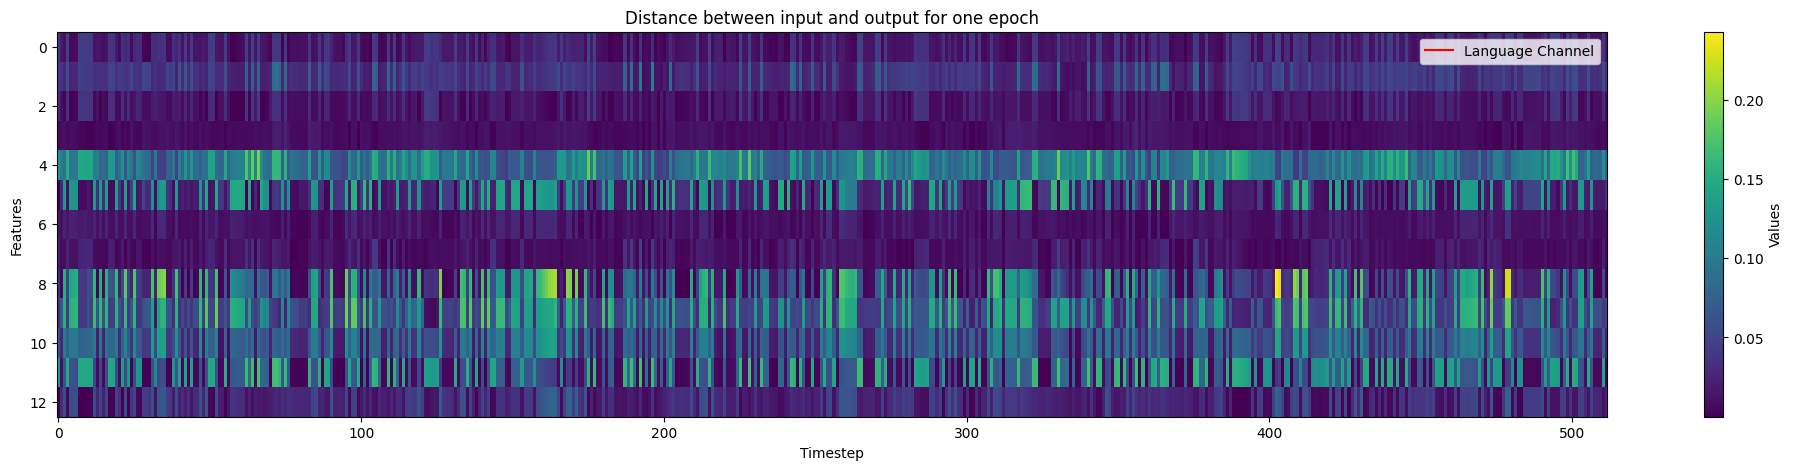

In [ ]:
print(distances[0])
plot_distances(distances, title="Distance between input and output for one epoch")